# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../src')

import config_snippets as conf_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf

In [3]:
# Path to your config YAML file
config_file_path = "..//..//config.yaml"

# Load the configuration
config = conf_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    train_period = ast.literal_eval(config.get("train_period"))
    test_period = ast.literal_eval(config.get("test_period"))
    

In [4]:
# Import data
path = "..//..//..//..//data//processed//finance//df_finance_processed_first_period_18102023.csv"
df_finance_first_period = pd.read_csv(path)

In [5]:
# Set date as index
df_finance_first_period.set_index("date", inplace=True)

In [6]:
df_finance_first_period

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2018-12-10,17.502,5.18,1.59,2.86,9.069,3.344,13.258,12.5,4.462,8.389
2018-12-11,17.365,5.17,1.60,2.84,9.131,3.344,13.213,12.5,4.439,8.333
2018-12-12,17.775,5.19,1.59,3.03,9.233,3.433,13.440,12.7,4.508,8.296
2018-12-13,17.673,5.20,1.61,3.20,9.110,3.388,13.462,12.9,4.508,8.315
2018-12-14,17.434,5.18,1.57,3.10,8.946,3.344,13.281,12.8,4.405,8.074
...,...,...,...,...,...,...,...,...,...,...
2020-01-19,11.304,3.88,1.03,2.63,10.016,3.254,9.115,10.6,3.414,8.111
2020-01-20,11.217,3.86,1.04,2.60,10.016,3.210,9.115,10.7,3.414,8.333
2020-01-21,11.174,3.92,1.07,2.64,10.266,3.299,9.115,10.9,3.425,8.722


# **Split data**

In [7]:
# Example: split ratio = 0.7
df_finance_train_first_period, df_finance_test_first_period = splitting_data.splitting_data_by_ratio(
    df_finance_first_period,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df_finance_first_period,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_finance_train_first_period

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2018-12-10,17.502,5.18,1.59,2.86,9.069,3.344,13.258,12.50,4.462,8.389
2018-12-11,17.365,5.17,1.60,2.84,9.131,3.344,13.213,12.50,4.439,8.333
2018-12-12,17.775,5.19,1.59,3.03,9.233,3.433,13.440,12.70,4.508,8.296
2018-12-13,17.673,5.20,1.61,3.20,9.110,3.388,13.462,12.90,4.508,8.315
2018-12-14,17.434,5.18,1.57,3.10,8.946,3.344,13.281,12.80,4.405,8.074
...,...,...,...,...,...,...,...,...,...,...
2019-09-18,14.956,4.54,1.23,3.15,9.948,2.809,9.790,10.20,3.307,7.815
2019-09-19,15.130,4.52,1.23,3.09,10.016,2.942,9.859,10.55,3.307,7.945
2019-09-20,14.695,4.46,1.23,3.18,10.039,2.898,9.722,10.35,3.295,7.926


## **Gatev Data Normalization**

In [10]:
df_finance_cum_daily_returns_train_first_period = gatev_dist.gatev_data_normalize(df_finance_train_first_period)

In [11]:
df_finance_cum_daily_returns_train_first_period

,adClose_DXG,adClose_HAG,adClose_HQC,adClose_ITA,adClose_MBB,adClose_SHB,adClose_SSI,adClose_STB,adClose_VND,adClose_VPB
date,,,,,,,,,,
2018-12-11,-0.782768,-1.930502e-01,0.628931,-0.699301,0.683648,0.000000e+00,-0.339418,0.0,-0.515464,-0.667541
2018-12-12,1.559822,1.930502e-01,0.000000,5.944056,1.808358,2.661483e+00,1.372756,1.6,1.030928,-1.108595
2018-12-13,0.977031,3.861004e-01,1.257862,11.888112,0.452090,1.315789e+00,1.538694,3.2,1.030928,-0.882108
2018-12-14,-0.388527,2.220446e-14,-1.257862,8.391608,-1.356269,2.220446e-14,0.173480,2.4,-1.277454,-3.754917
2018-12-15,-0.388527,2.220446e-14,-1.257862,8.391608,-1.356269,2.220446e-14,0.173480,2.4,-1.277454,-3.754917
...,...,...,...,...,...,...,...,...,...,...
2019-09-18,-14.546909,-1.235521e+01,-22.641509,10.139860,9.692359,-1.599880e+01,-26.157792,-18.4,-25.885253,-6.842293
2019-09-19,-13.552737,-1.274131e+01,-22.641509,8.041958,10.442166,-1.202153e+01,-25.637351,-15.6,-25.885253,-5.292645
2019-09-20,-16.038167,-1.389961e+01,-22.641509,11.188811,10.695777,-1.333732e+01,-26.670689,-17.2,-26.154191,-5.519132


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_finance_cum_daily_returns_train_first_period)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_finance_cum_daily_returns_train_first_period,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_HAG và adClose_SHB: 123.5
Khoảng cách Euclide của adClose_HQC và adClose_SSI: 90.0
Khoảng cách Euclide của adClose_HQC và adClose_STB: 113.7
Khoảng cách Euclide của adClose_HQC và adClose_VND: 113.0
Khoảng cách Euclide của adClose_HQC và adClose_VPB: 89.7
Khoảng cách Euclide của adClose_SHB và adClose_STB: 43.0
Khoảng cách Euclide của adClose_SSI và adClose_STB: 120.2
Khoảng cách Euclide của adClose_SSI và adClose_VND: 88.3
Khoảng cách Euclide của adClose_SSI và adClose_VPB: 118.9
Khoảng cách Euclide của adClose_VND và adClose_VPB: 113.8
[['adClose_HAG', 'adClose_SHB'], ['adClose_HQC', 'adClose_SSI'], ['adClose_HQC', 'adClose_STB'], ['adClose_HQC', 'adClose_VND'], ['adClose_HQC', 'adClose_VPB'], ['adClose_SHB', 'adClose_STB'], ['adClose_SSI', 'adClose_STB'], ['adClose_SSI', 'adClose_VND'], ['adClose_SSI', 'adClose_VPB'], ['adClose_VND', 'adClose_VPB']]


In [15]:
gatev_pairs

[['adClose_HAG', 'adClose_SHB'],
 ['adClose_HQC', 'adClose_SSI'],
 ['adClose_HQC', 'adClose_STB'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_HQC', 'adClose_VPB'],
 ['adClose_SHB', 'adClose_STB'],
 ['adClose_SSI', 'adClose_STB'],
 ['adClose_SSI', 'adClose_VND'],
 ['adClose_SSI', 'adClose_VPB'],
 ['adClose_VND', 'adClose_VPB']]

# **Cointegration Approach**

## **Data Transformation**

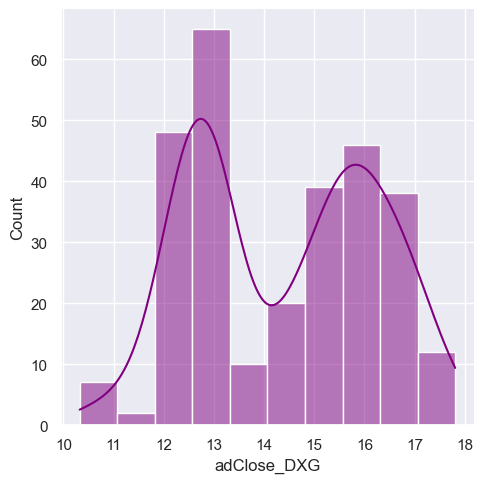

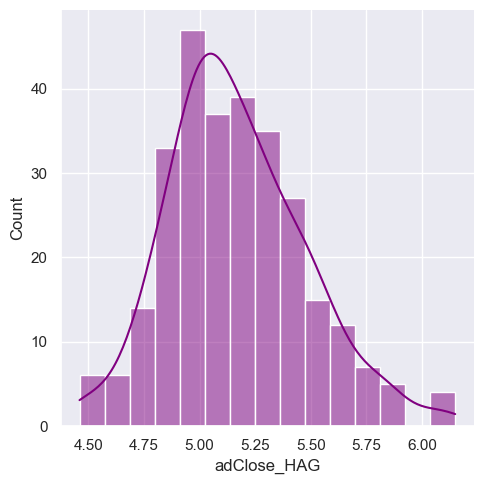

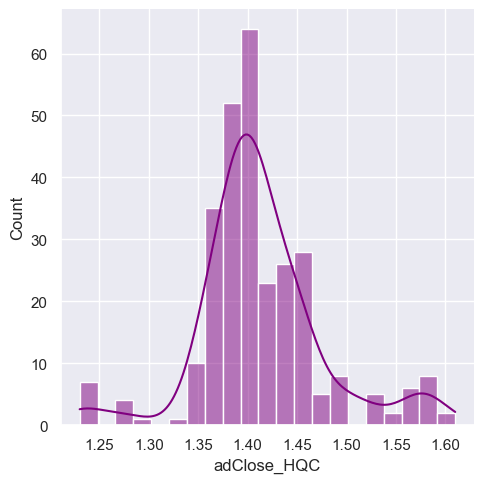

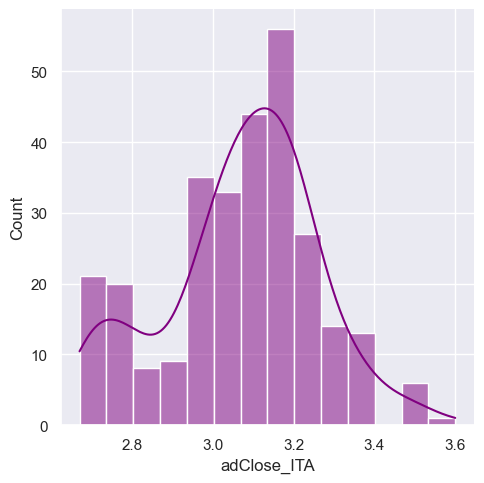

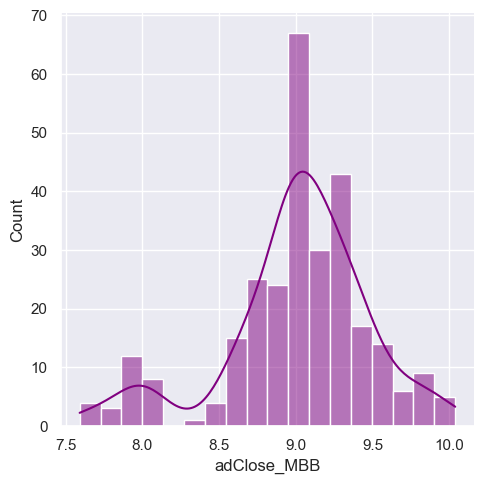

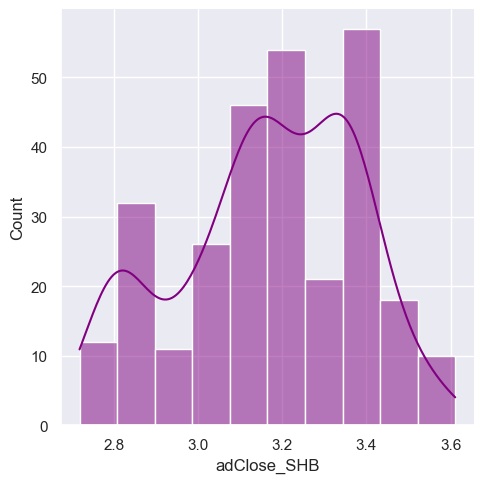

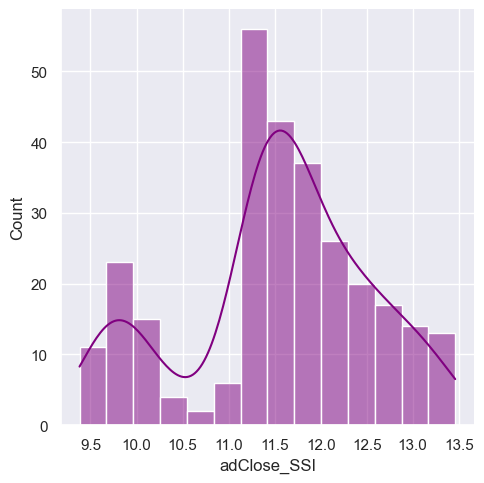

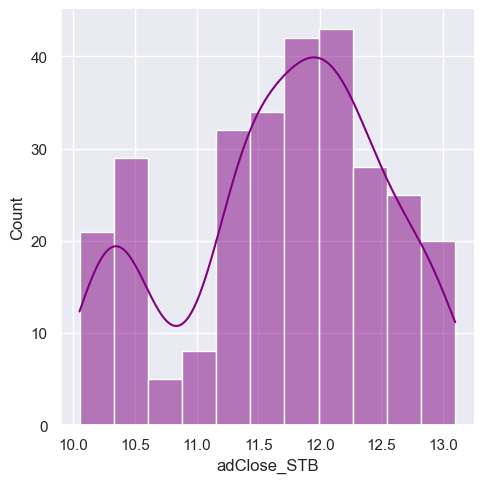

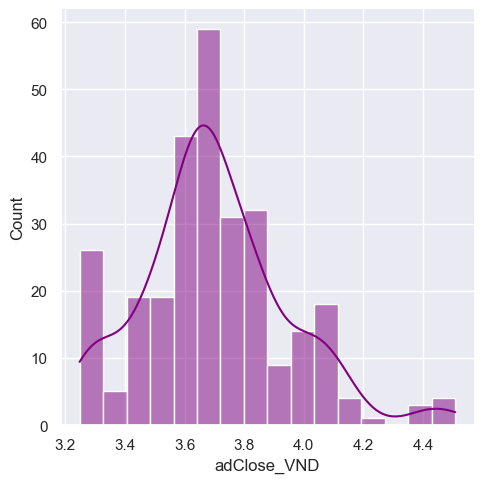

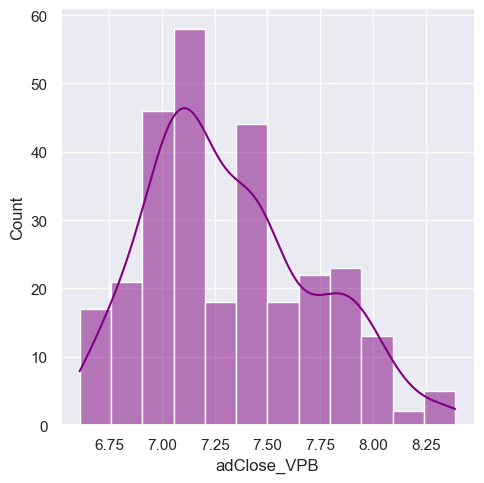

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_finance_train_first_period)

In [17]:
# Take natural log transformation of the data  
df_finance_train_transformed_first_period = data_transform_snp.df_natural_log_transformed(df_finance_train_first_period)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_finance_train_transformed_first_period)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_finance_train_transformed_first_period)

,Column Name,Integration Order
0,adClose_DXG,1
1,adClose_HAG,1
2,adClose_HQC,1
3,adClose_ITA,1
4,adClose_MBB,1
5,adClose_SHB,1
6,adClose_SSI,1
7,adClose_STB,1
8,adClose_VND,1
9,adClose_VPB,1


## **Engle - Grange Method**

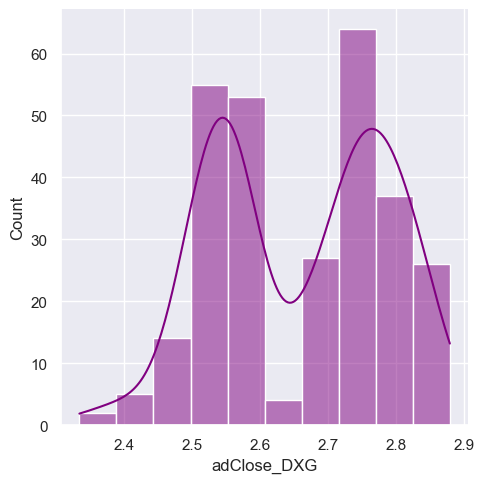

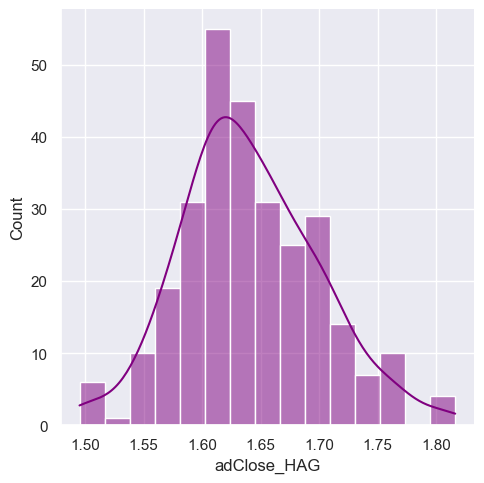

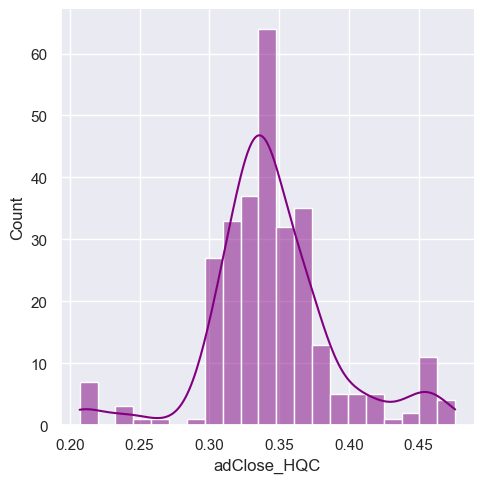

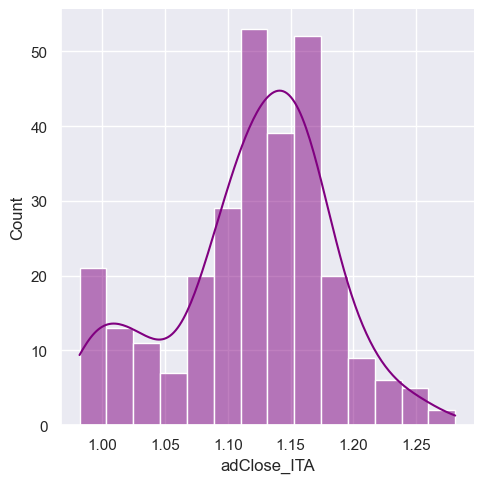

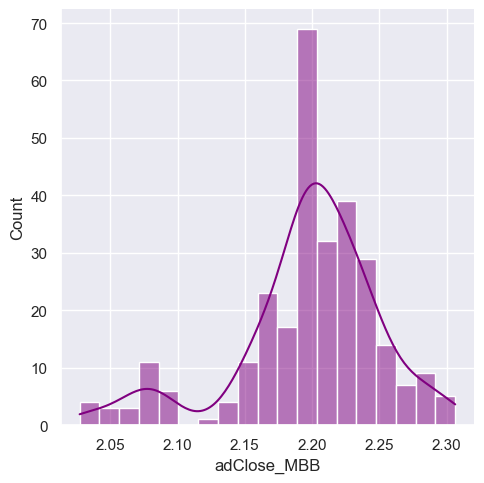

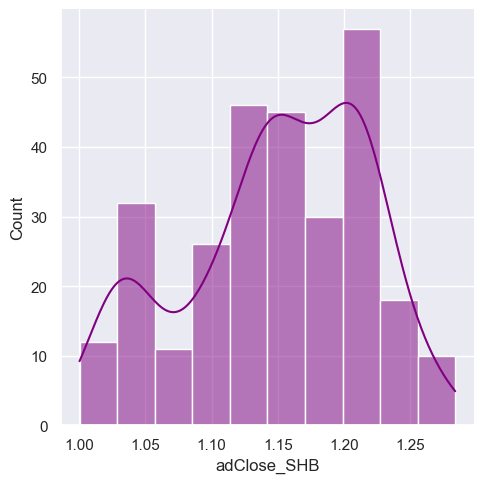

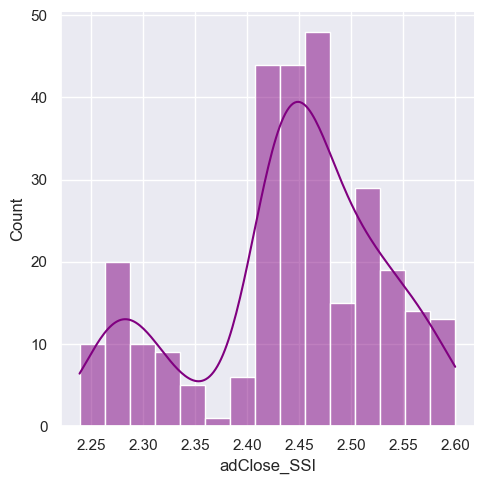

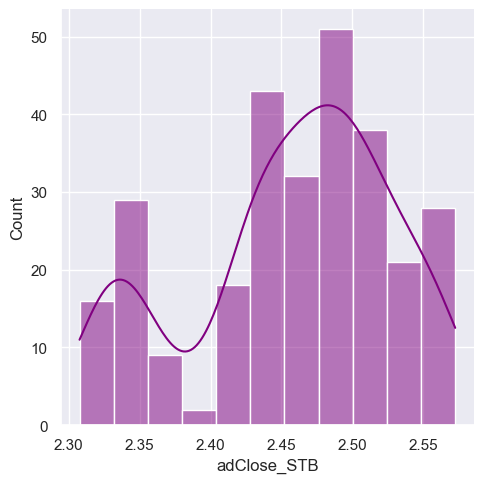

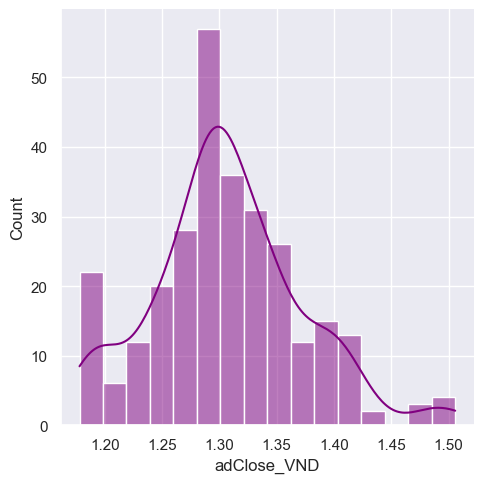

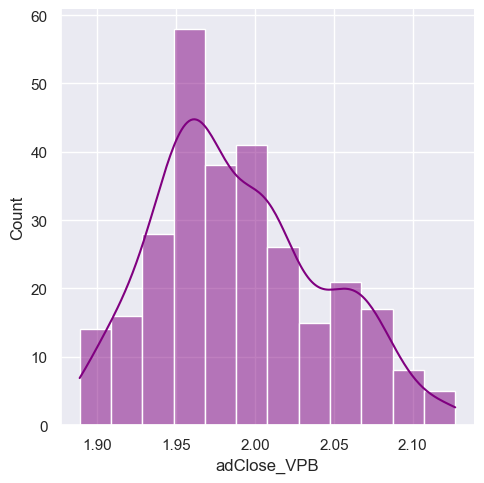

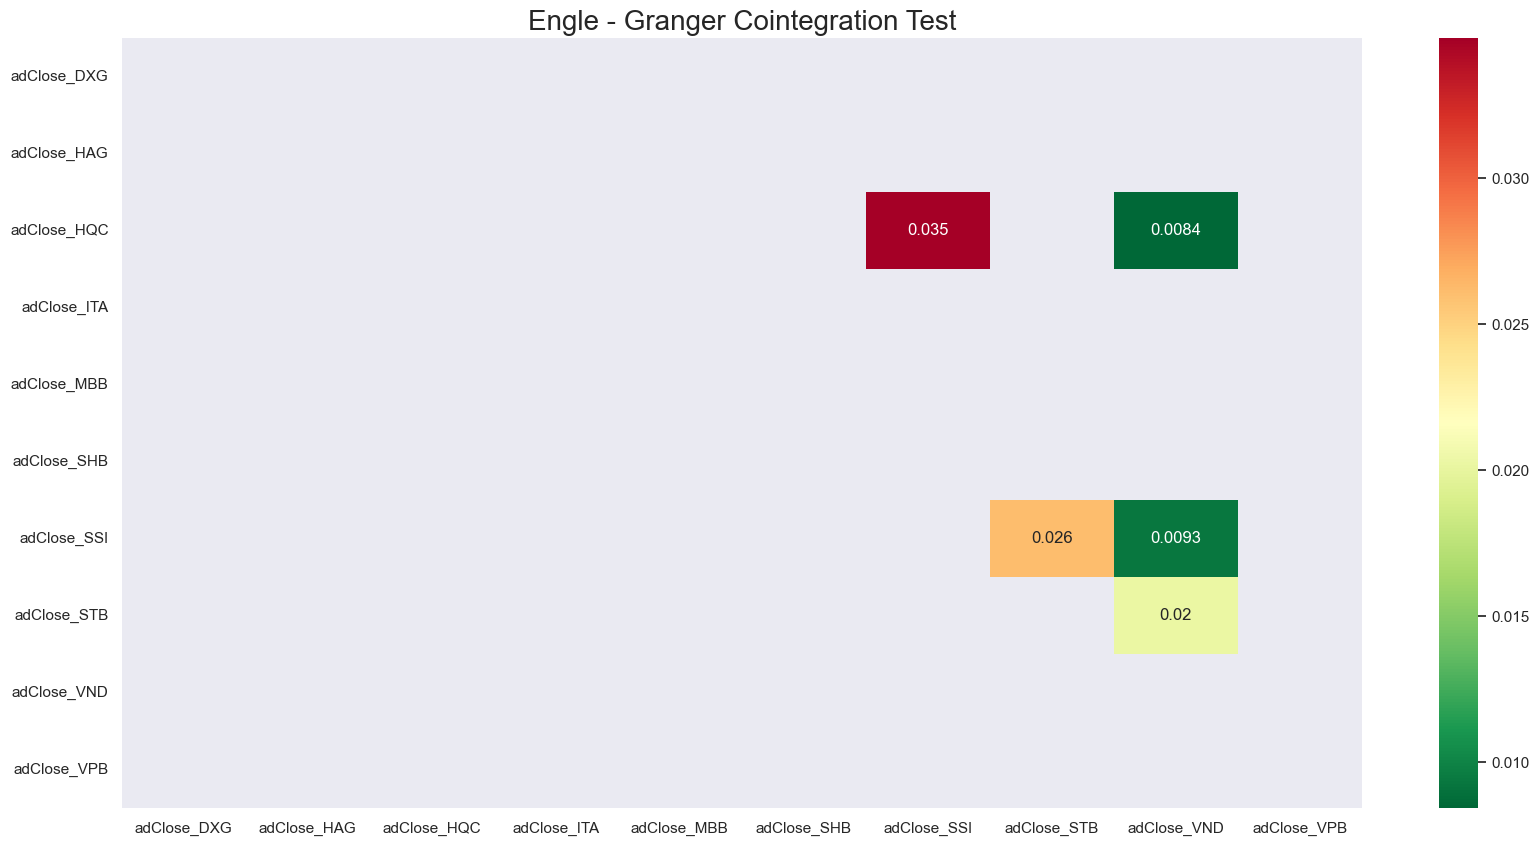

In [20]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_finance_train_transformed_first_period)

In [21]:
eg_pairs 

[['adClose_HQC', 'adClose_SSI'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_SSI', 'adClose_STB'],
 ['adClose_SSI', 'adClose_VND'],
 ['adClose_STB', 'adClose_VND']]

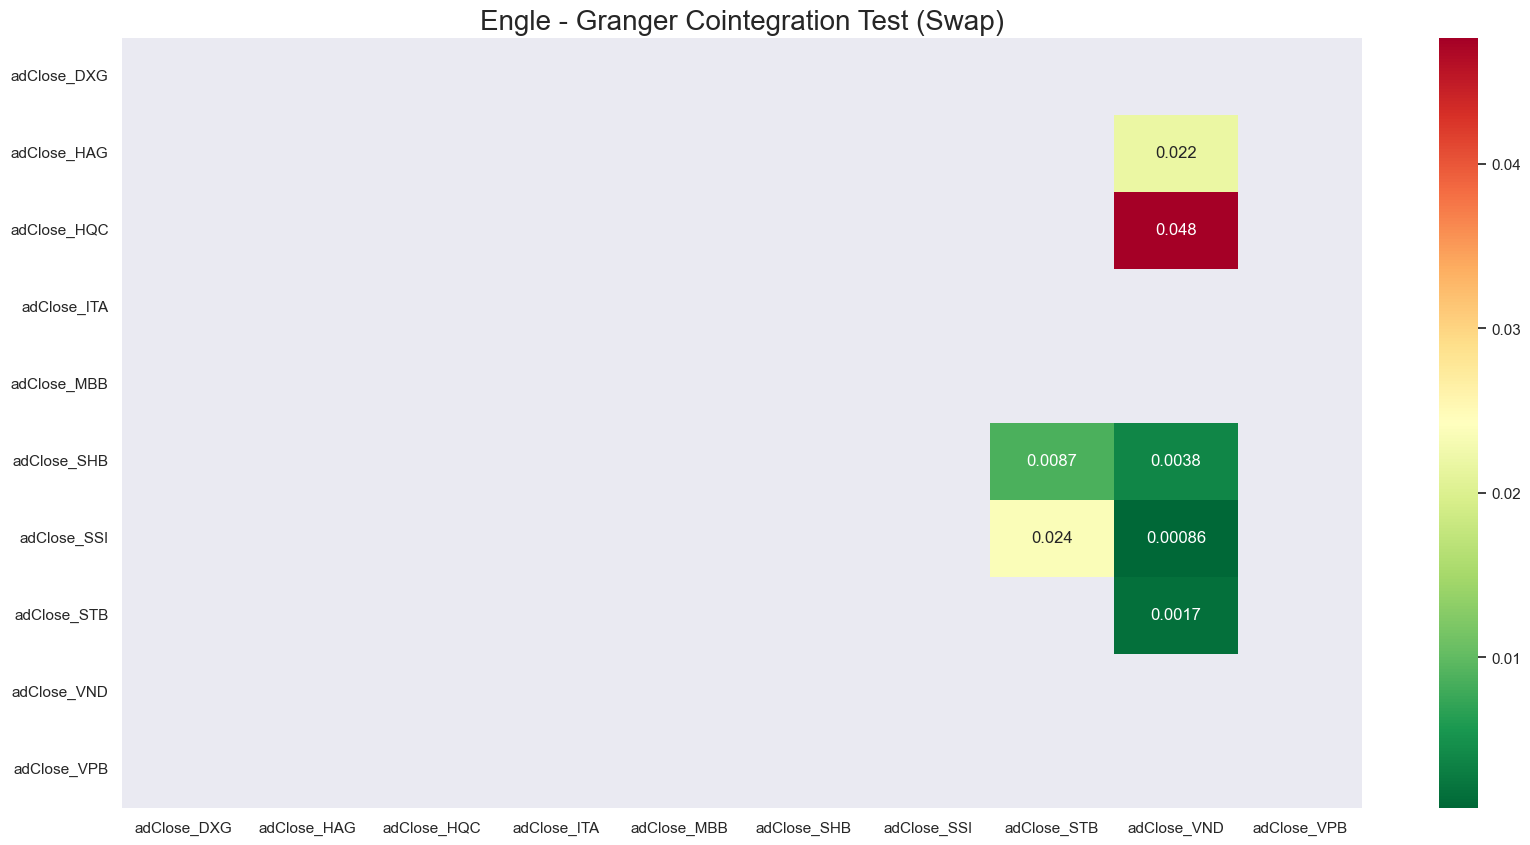

In [22]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_finance_train_transformed_first_period)

In [23]:
eg_pairs_swap

[['adClose_HAG', 'adClose_VND'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_SHB', 'adClose_STB'],
 ['adClose_SHB', 'adClose_VND'],
 ['adClose_SSI', 'adClose_STB'],
 ['adClose_SSI', 'adClose_VND'],
 ['adClose_STB', 'adClose_VND']]

## **Johansen Method**

In [24]:
johansen_pairs = jj_coint.johansen_test(df_finance_train_transformed_first_period)

In [25]:
johansen_pairs

[['adClose_HAG', 'adClose_ITA'],
 ['adClose_HAG', 'adClose_VND'],
 ['adClose_HQC', 'adClose_MBB'],
 ['adClose_HQC', 'adClose_SSI'],
 ['adClose_HQC', 'adClose_VND'],
 ['adClose_HQC', 'adClose_VPB'],
 ['adClose_ITA', 'adClose_SHB'],
 ['adClose_ITA', 'adClose_VND'],
 ['adClose_ITA', 'adClose_VPB'],
 ['adClose_SHB', 'adClose_VND'],
 ['adClose_SSI', 'adClose_STB'],
 ['adClose_SSI', 'adClose_VND'],
 ['adClose_STB', 'adClose_VND']]

# **Result Summary**

In [26]:
df_finance_pairs_formation_train_first_period = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

d:\ACADEMIC LIFE\EDU\RESEARCH\CURRENT\PAIR TRADING UPGRADE\PAIR TRADING UPGRADE REPO\notebooks\main_notebooks\pairs_formation\finance_pairs_formation\../../../../src\handling_dataframe.py:164: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [27]:
df_finance_pairs_formation_train_first_period

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_HAG,adClose_ITA,,,,x,1
1,adClose_HAG,adClose_SHB,x,,,,1
2,adClose_HAG,adClose_VND,,,x,x,2
3,adClose_HQC,adClose_MBB,,,,x,1
4,adClose_HQC,adClose_SSI,x,x,,x,3
5,adClose_HQC,adClose_STB,x,,,,1
6,adClose_HQC,adClose_VND,x,x,x,x,4
7,adClose_HQC,adClose_VPB,x,,,x,2
8,adClose_ITA,adClose_SHB,,,,x,1
9,adClose_ITA,adClose_VND,,,,x,1
